# Task 1: Feed-forward neural networks


---

Tutorial: "Machine Learning in Solid Mechanics @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Assistants: Dominik K. Klein, Jasper O. Schommartz

---





*Run the following cell to clone the GitHub repository in your current Google Colab environment and install the local package. For the changes to take effect you might need to restart your Colabl session first ("Runtime / Restart session" in the header menu).*

In [3]:
!git clone --depth 1 https://github.com/CPShub/TutorialMLinSolidMechanics.git
!cd TutorialMLinSolidMechanics/ffnn_introduction
!pip install -e .

Cloning into 'TutorialMLinSolidMechanics'...
The system cannot find the path specified.


Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///C:/Users/schommartz/Documents/git_environment/tutorialmlinsolidmechanics/ffnn_introduction
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of tmlsm to determine which version is compatible with other requirements. This could take a while.


ERROR: Package 'tmlsm' requires a different Python: 3.11.9 not in '>=3.12'


*Run the following cell to import all modules and python files to this notebook. If you made changes in the python files, run the following cell again to update the python files in this notebook. You might need to restart your Colab session first ("Runtime / Restart session" in the header menu).*

In [4]:
import datetime
import importlib

import jax
import jax.random as jrandom
import klax
from matplotlib import pyplot as plt
import time

import tmlsm.losses as tl
import tmlsm.data as td
import tmlsm.models as tm

importlib.reload(tm)
importlib.reload(tl)
importlib.reload(td)

now = datetime.datetime.now

*If you want to clone the repository again, you have to delete it from your Google Colab files first. For this, you can run the following cell.*

In [ ]:
%rm -rf TutorialMLinSolidMechanics

### Load data and model

In [5]:
# Create random key for reproducible weight initialization, and
# batch splits. The call to `time.time_ns()` may be replaced with
# a constant seed if exactly reproductible results ought to be
# produced.
key = jrandom.PRNGKey(time.time_ns())
keys = jrandom.split(key, 2)

# Build model instance
model = tm.build(key=keys[0])

# Load data
x, y, x_cal, y_cal = td.bathtub()

print(model)

Model(
  layers=(
    Linear(
      weight=f32[1,16],
      bias=f32[16],
      in_features='scalar',
      out_features=16,
      use_bias=True
    ),
    Linear(
      weight=f32[16,16],
      bias=f32[16],
      in_features=16,
      out_features=16,
      use_bias=True
    ),
    Linear(
      weight=f32[16,1],
      bias=f32[1],
      in_features=16,
      out_features='scalar',
      use_bias=True
    )
  ),
  activations=(
    <PjitFunction of <function softplus at 0x0000022699B2BB00>>,
    <PjitFunction of <function softplus at 0x0000022699B2BB00>>,
    <function Model.__init__.<locals>.<lambda>>
  )
)


2025-10-13 22:20:43.452942
Step: 0, Loss: 1.416e+00
Step: 1, Loss: 1.287e+00
Step: 2, Loss: 1.165e+00
Step: 3, Loss: 1.049e+00
Step: 4, Loss: 9.408e-01
Step: 5, Loss: 8.392e-01
Step: 6, Loss: 7.449e-01
Step: 7, Loss: 6.575e-01
Step: 8, Loss: 5.770e-01
Step: 9, Loss: 5.027e-01
Step: 10, Loss: 4.348e-01
Step: 11, Loss: 3.735e-01
Step: 12, Loss: 3.189e-01
Step: 13, Loss: 2.702e-01
Step: 14, Loss: 2.270e-01
Step: 15, Loss: 1.896e-01
Step: 16, Loss: 1.572e-01
Step: 17, Loss: 1.300e-01
Step: 18, Loss: 1.075e-01
Step: 19, Loss: 8.946e-02
Step: 20, Loss: 7.554e-02
Step: 21, Loss: 6.487e-02
Step: 22, Loss: 5.718e-02
Step: 23, Loss: 5.202e-02
Step: 24, Loss: 4.901e-02
Step: 25, Loss: 4.767e-02
Step: 26, Loss: 4.773e-02
Step: 27, Loss: 4.880e-02
Step: 28, Loss: 5.053e-02
Step: 29, Loss: 5.272e-02
Step: 30, Loss: 5.520e-02
Step: 31, Loss: 5.760e-02
Step: 32, Loss: 5.994e-02
Step: 33, Loss: 6.196e-02
Step: 34, Loss: 6.373e-02
Step: 35, Loss: 6.521e-02
Step: 36, Loss: 6.628e-02
Step: 37, Loss: 6.669

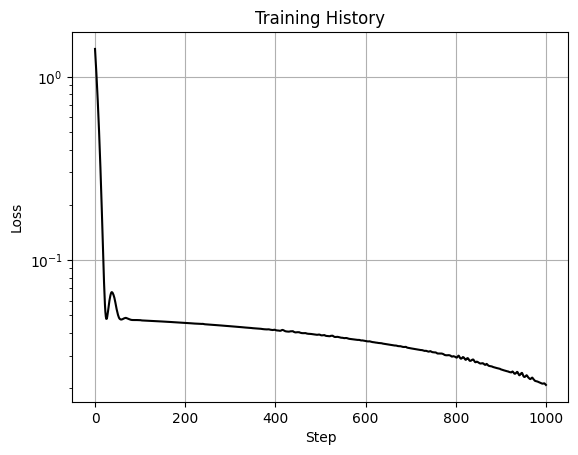

In [6]:
# Calibrate model
t1 = now()
print(t1)

model, history = klax.fit(
    model,
    (x_cal, y_cal),
    batch_size=32,
    steps=1_000,
    loss_fn=tl.MSE(),
    history=klax.HistoryCallback(log_every=1),
    key=keys[1],
)

t2 = now()
print("it took", t2 - t1, "(sec) to calibrate the model")

history.plot()

### Model evaluation

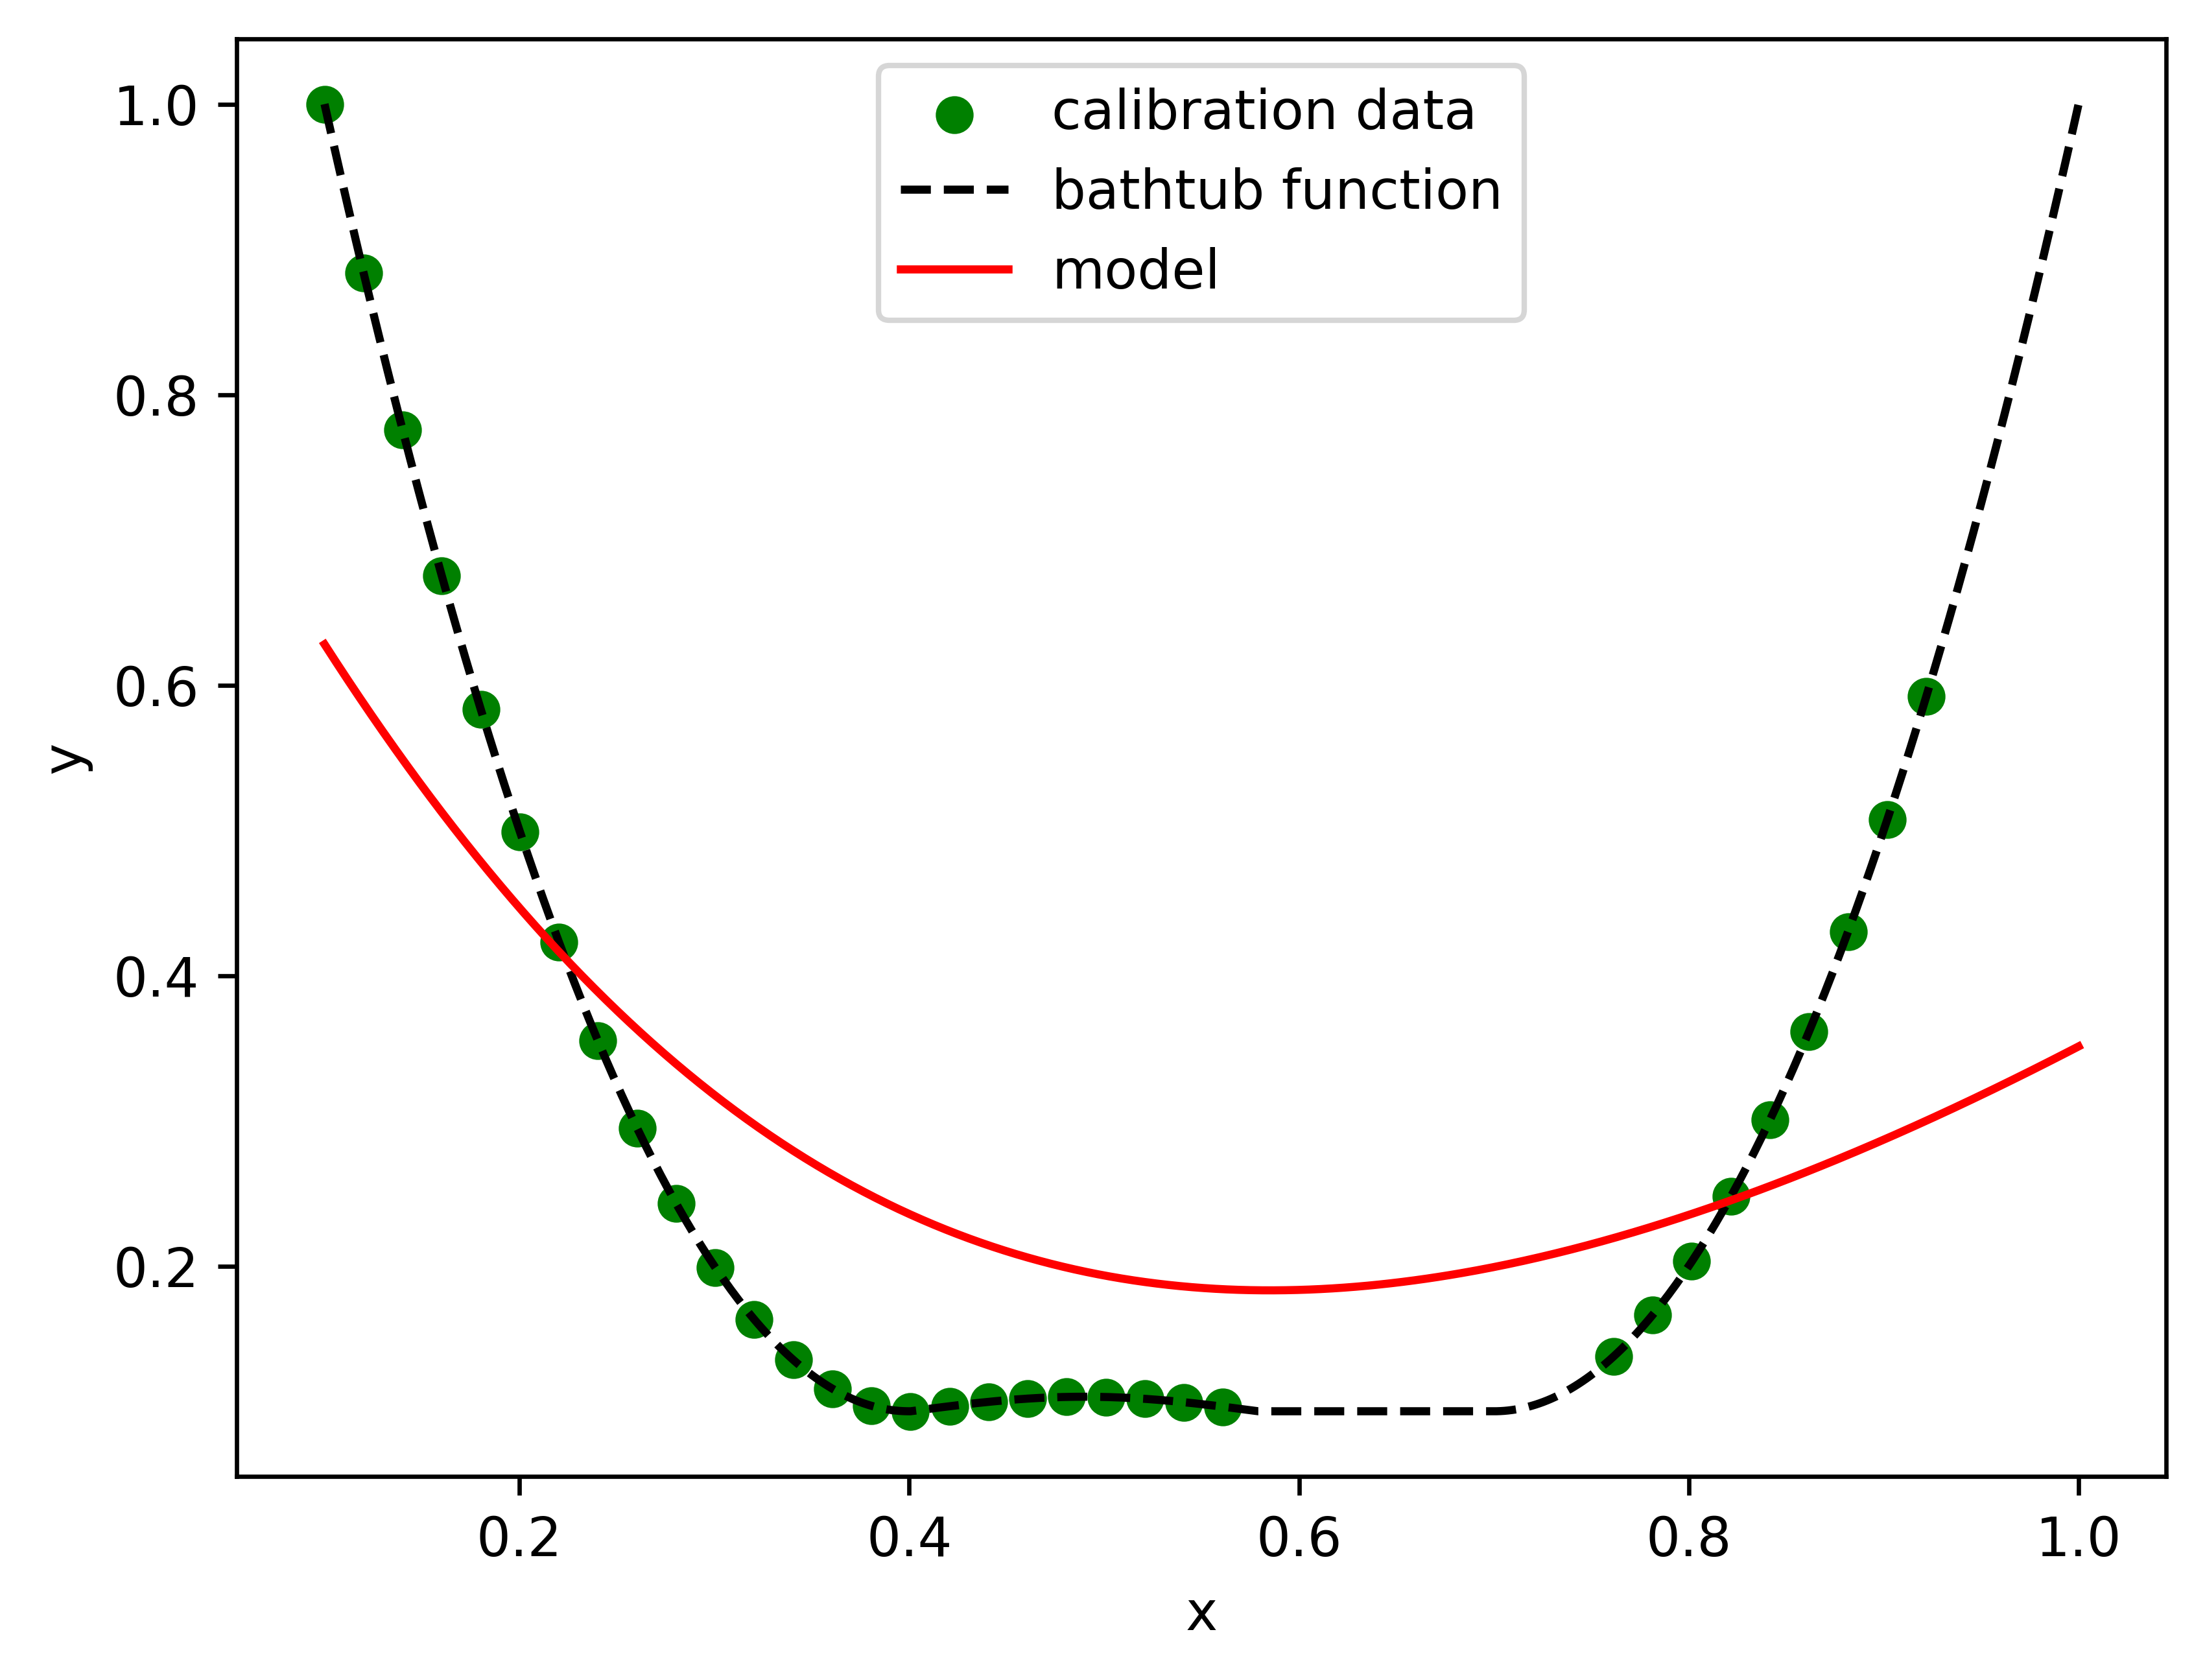

In [7]:
# First the model need to be finalized to unwrap and apply all
# wrappers and constraints (if present).
model_ = klax.finalize(model)

plt.figure(2)
plt.scatter(x_cal[::10], y_cal[::10], c="green", label="calibration data")
plt.plot(x, y, c="black", linestyle="--", label="bathtub function")
plt.plot(x, jax.vmap(model_)(x), label="model", color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()